 #water softener signal detection Test
 writen by : amenallah salem¹

 Test Goal:
 - writing an algorithm wich count the number of occurrences of water softener running over the course 
 - proposing different approaches to detect the water softener signal 




 amenallah.salem@dauphine.eu/ amenallah.salem@dauphine.tn 
 

##Loading & discovering the dataset


In [1]:
#Importing packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.layers import GRU
import pytz#python time zone

Using TensorFlow backend.


In [0]:
##Loading the data
######### loding the data from Google Drive:if working on google colab#########
#from google.colab import files
#uploaded = files.upload() #select the file on your drive 
#and then put the data into a pandas dataframe
#import io
#data =pd.read_csv(io.BytesIO(uploaded['expot.csv']))
############################## loding the data from github ###############
dataLink = 'https://raw.githubusercontent.com/amenallah-salem/waterSoftenerTest/master/expot.csv'
data = pd.read_csv(dataLink)
############################## if we are testing the code on other dataset ###########
#def getData(dataLink_):
#  return pd.read_csv(dataLink)
#data = getData("dataLink")

In [3]:
data.head()


,device_id,timestamp,pulses,consolidation
0,3A9B9D,2019-03-01 00:00,0,1
1,3A9B9D,2019-03-01 00:06,1,1
2,3A9B9D,2019-03-01 00:12,0,1
3,3A9B9D,2019-03-01 00:18,0,1
4,3A9B9D,2019-03-01 00:24,0,1


In [4]:
#check if we have missing value
data.isnull().values.any()

False

In [5]:
#check if we have a duplicated rows
data.duplicated().any()

False

In [6]:
#some statistics
data.describe()

,pulses,consolidation
count,87520.000000,87520.000000
mean,1.136426,0.981239
std,1.843377,0.152793
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,2.000000,1.000000
max,25.000000,6.000000


In [7]:
#some statistics
data.describe()

,pulses,consolidation
count,87520.000000,87520.000000
mean,1.136426,0.981239
std,1.843377,0.152793
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,2.000000,1.000000
max,25.000000,6.000000


In [8]:
data.dtypes

device_id        object
timestamp        object
pulses            int64
consolidation     int64
dtype: object

In [0]:
def dataProcessing(data_):
  ###converting the timestamp to datetime"
  data_["timestamp"] = pd.to_datetime(data_["timestamp"])
  data_.drop(columns=['device_id'], inplace=True)
  data_.drop(columns=['consolidation'], inplace=True)

In [0]:
dataProcessing(data)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'pulses in time function')

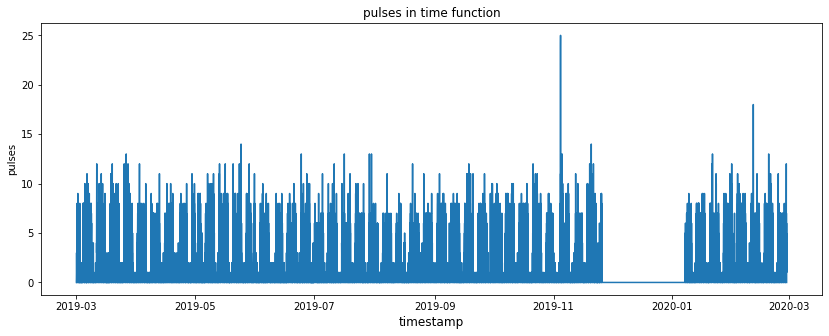

In [11]:
f, (ax1) = plt.subplots(1, figsize=(14,5))
ax1.plot(data["timestamp"], data["pulses"])
ax1.set_xlabel("timestamp", fontsize=12)
ax1.set_ylabel("pulses")
ax1.set_title("pulses in time function")

In [0]:
def timeSession(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'
def secondData(data_):
  ###adding columns for some visualisation 
  data_['Weekday'] = data_['timestamp'].dt.day_name()
  data_['Month'] = data_.timestamp.map(lambda x : x.month)
  data_['Year'] = data_.timestamp.map(lambda x : x.year)
  data_['Date'] = [d.date() for d in data_['timestamp']]
  data_["Date"] = pd.to_datetime(data_["Date"])
  data_['date'] = data_.timestamp.apply(lambda x: x.strftime('%Y-%m-%d'))  
  data_['Time'] = [d.time() for d in data_['timestamp']]
  data_['Hour'] = data_.timestamp.map(lambda x : x.hour)
  data_['Day session'] = data_['Hour'].apply(timeSession)

In [13]:
#I have created a copy of data to add columns of different sets mmaybe to discver technical indicators
data2 = data.copy()
data2.head()

,timestamp,pulses
0,2019-03-01 00:00:00,0
1,2019-03-01 00:06:00,1
2,2019-03-01 00:12:00,0
3,2019-03-01 00:18:00,0
4,2019-03-01 00:24:00,0
...,...,...
87515,2020-02-28 15:30:00,0
87516,2020-02-28 15:36:00,0
87517,2020-02-28 15:42:00,0
87518,2020-02-28 15:48:00,0


In [0]:
secondData(data2)


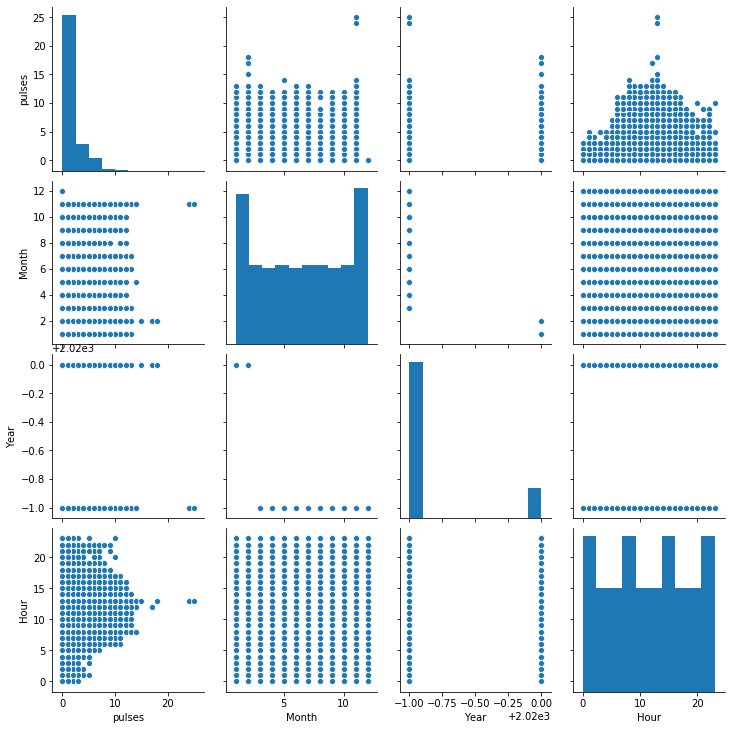

In [15]:
#Now let's see what our data looks like we want it with various patterns occurring over time.
import seaborn as sns
# Create the default pairplot
sns.pairplot(data2)#, hue = 'pulses'

##First part of the Test 
writing an algorithm that will count the number of occurrences of water softener running over the course of the time of the dataset

In [0]:
#we will create subset of data with our pulses values and then use shape 
def occurence(x_):
  setOfPulseQuantity = set(data.pulses)
  indexList=[]
  if x_ in setOfPulseQuantity : 
    occuranceNumber= data[data['pulses'] ==x_].shape[0]
    indexList.append(data[data['pulses'] ==x_].index)
    print('the number of occurrences of {} pulse = {} littre(s)  is {} time(s)and this happend at \n {} '.format(x_,x_*10,occuranceNumber, indexList))

##The construction of the models
Now that we have done some initial discorery on our data,we first split the train and test data and use cross validation over the entire dataset. we also format our data so that it would be easier for us to analyze. We can use MinMaxScaler() to normalize the data between 0 and 1. Normalization help the process to become faster and help understand the network the data better.


data preparation


In [0]:
# splitting the dataset into the Training set and Test set
#we are taiking the trainingset 80% OF THE DATA 
data=data.set_index(['timestamp'])
train_len = int(len(data)-(len(data)/100)*80)
train = data.iloc[:train_len]
test = data.iloc[train_len:]



In [0]:
scaler = MinMaxScaler(feature_range = (0,1))
training_set_scaled = scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [0]:
n_input = 12 #WINDOW_SIZE
n_features= 1#= x_train.shape[-1]
BATCH_SIZE=64
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=BATCH_SIZE)

We will use a simple LSTM and try to see how it performs. We use three layers with few nodes to implement the model and mean square error for loss function. A summary of the entire block has been given below.

We will use EarlyStopping to function in keras which can stop if we get a consistent low loss of the network.

In [21]:
# define model 
model = Sequential()
model.add(LSTM(120, activation='relu', return_sequences = True, input_shape=(n_input, n_features)))

model.add(LSTM(120, activation='relu', return_sequences = True))
model.add(Dropout(0.2))


model.add(LSTM(120, activation='relu', return_sequences = False))
model.add(Dropout(0.2))


#model.add(Activation('linear'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 120)           58560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 120)           115680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 120)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 121       
Total params: 290,041
Trainable params: 290,041
Non-trainable params: 0
________________________________________________

In [23]:
model.fit_generator(generator,epochs=BATCH_SIZE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/64





274/274 [==============================] - 23s 84ms/step - loss: 0.0093
Epoch 2/64
274/274 [==============================] - 21s 75ms/step - loss: 0.0081
Epoch 3/64
274/274 [==============================] - 21s 75ms/step - loss: 0.0082
Epoch 4/64
274/274 [==============================] - 21s 75ms/step - loss: 0.0078
Epoch 5/64
274/274 [==============================] - 21s 75ms/step - loss: 0.0076
Epoch 6/64
274/274 [==============================] - 20s 75ms/step - loss: 0.0078
Epoch 7/64
274/274 [==============================] - 21s 75ms/step - loss: 0.0076
Epoch 8/64
274/274 [==============================] - 21s 75ms/step - loss: 0.0076
Epoch 9/64
274/274 [==============================] - 20s 75ms/step - loss: 0.0076
Epoch 10/64
274/274 [==============================] - 21s 75ms/step - loss: 0.0076
Epoch 11/64
274/274 [==============================] - 20s 74ms/ste

In [24]:
#Learning histrory
model.history.history.keys()

dict_keys(['loss'])

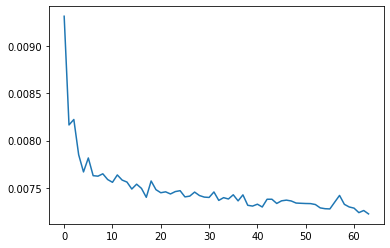

In [25]:
#plot de fct loss
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [0]:
#first_eval_batch = scaled_train[-12:]

In [0]:
#first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

#GRU mode
remark : we create GRU mode with the same parameteres and configurations of LSTM ( to make some importante insites)

In [0]:
from keras.layers.normalization import BatchNormalization

model2 = Sequential()
model2.add(GRU(128,return_sequences=True, input_shape=(n_input,n_features)))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(GRU(128,return_sequences=False))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')


In [34]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 12, 128)           49920     
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 128)           512       
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               98688     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

Here, both LSTM and GRU had the same architecture but the number of parameters in LSTM is 290,41 whereas GRU in GRU is 149.761. As we already discussed the differences, GRU with two gates compared to LSTM that has three gates. GRU has fewer parameters it is computationally more efficient than LSTM.

In [30]:
model2.fit_generator(generator,epochs=BATCH_SIZE)

Epoch 1/64
274/274 [==============================] - 14s 51ms/step - loss: 0.3953
Epoch 2/64
274/274 [==============================] - 12s 44ms/step - loss: 0.1609
Epoch 3/64
274/274 [==============================] - 12s 45ms/step - loss: 0.0883
Epoch 4/64
274/274 [==============================] - 12s 44ms/step - loss: 0.0488
Epoch 5/64
274/274 [==============================] - 12s 45ms/step - loss: 0.0320
Epoch 6/64
274/274 [==============================] - 12s 45ms/step - loss: 0.0253
Epoch 7/64
274/274 [==============================] - 12s 45ms/step - loss: 0.0231
Epoch 8/64
274/274 [==============================] - 13s 46ms/step - loss: 0.0219
Epoch 9/64
274/274 [==============================] - 12s 45ms/step - loss: 0.0209
Epoch 10/64
274/274 [==============================] - 12s 45ms/step - loss: 0.0204
Epoch 11/64
274/274 [==============================] - 12s 45ms/step - loss: 0.0204
Epoch 12/64
274/274 [==============================] - 12s 45ms/step - loss: 0.0202
E

In [32]:
#Learning histrory
model2.history.history.keys()

dict_keys(['loss'])

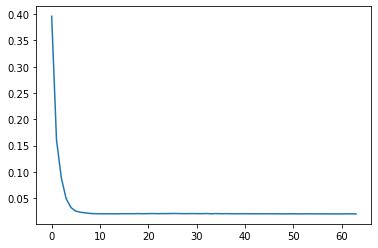

In [33]:
#plot de fct loss
loss2_per_epoch = model2.history.history['loss']
plt.plot(range(len(loss2_per_epoch)),loss2_per_epoch)

#Models evaluation


In [0]:
#Diagnostic Plots
#The training history of both LSTM & GRU models are used to diagnose the behavior
#of the models. I have created a single plot for the ease of convenience.

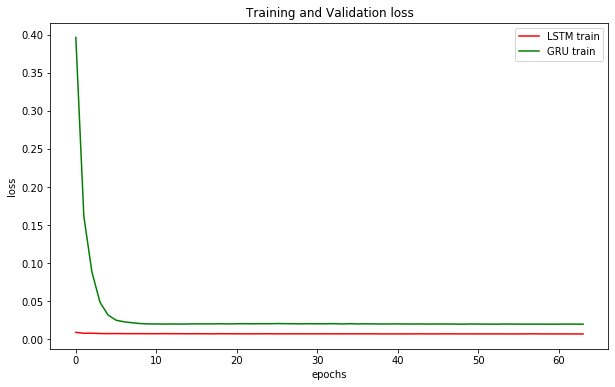

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(loss_per_epoch)),loss_per_epoch, label='LSTM train', color='red')
plt.plot(range(len(loss2_per_epoch)),loss2_per_epoch, label='GRU train', color='green')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()
